In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import numpy as np

paths = [
    Path("../../../analysis/mouse_m01_d2/03_simclr_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m01_d2/05_vgg19_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m02_d3/03_simclr_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m02_d3/05_vgg19_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m03_d4/03_simclr_neural/explained_variance.json"),
    Path("../../../analysis/mouse_m03_d4/05_vgg19_neural/explained_variance.json"),
]

all_data = []
for path in paths:
    with open(path) as f:
        all_data.extend(json.load(f))

# Average CEV across subsamples per mouse
mouse_level = {}
for entry in all_data:
    key = (entry["model"], entry["layer"], entry["mouse_id"])
    all_cevs = [np.array(s["cumulative_ev"]) for s in entry["subsamples"]]
    mean_cev = np.mean(all_cevs, axis=0)
    mouse_level[key] = mean_cev

# Organise into dataframe
records = []
for (model, layer, mouse_id), cev_array in mouse_level.items():
    for i, cev in enumerate(cev_array):
        records.append({
            "model": model,
            "layer": layer,
            "mouse_id": mouse_id,
            "component": i + 1,
            "cev": cev
        })

df = pd.DataFrame(records)
df.head(20)

,model,layer,mouse_id,component,cev
0,simclr,layer1,m01_d2,1,0.015581
1,simclr,layer1,m01_d2,2,0.025306
2,simclr,layer1,m01_d2,3,0.033990
3,simclr,layer1,m01_d2,4,0.042340
4,simclr,layer1,m01_d2,5,0.050265
5,simclr,layer1,m01_d2,6,0.058012
6,simclr,layer1,m01_d2,7,0.065586
7,simclr,layer1,m01_d2,8,0.073106
8,simclr,layer1,m01_d2,9,0.080489
9,simclr,layer1,m01_d2,10,0.087751


In [2]:
# Average across mice
summary = (
    df.groupby(["model", "layer", "component"])
      .agg(mean_cev=("cev", "mean"),
           sem_cev=("cev", lambda x: x.std(ddof=1) / np.sqrt(len(x))))
      .reset_index()
)
summary.head(20)

,model,layer,component,mean_cev,sem_cev
0,simclr,fc,1,0.115345,0.001233
1,simclr,fc,2,0.190728,0.000789
2,simclr,fc,3,0.234854,0.000888
3,simclr,fc,4,0.275791,0.001273
4,simclr,fc,5,0.314614,0.000935
5,simclr,fc,6,0.345204,0.000908
6,simclr,fc,7,0.373269,0.000647
7,simclr,fc,8,0.400103,0.000372
8,simclr,fc,9,0.425853,0.000221
9,simclr,fc,10,0.448984,0.000482


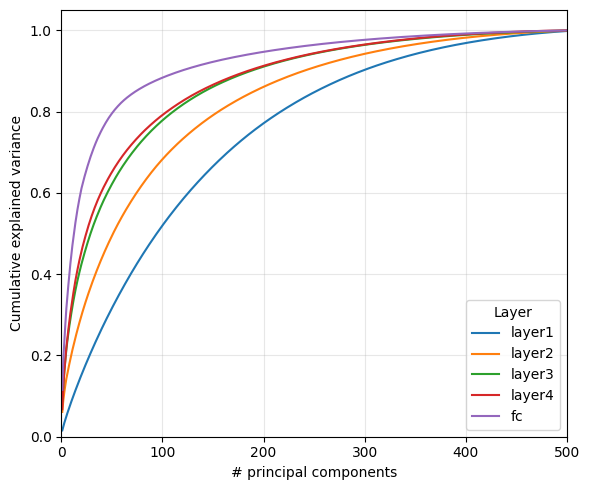

In [6]:
desired_order = ['layer1', 'layer2', 'layer3', 'layer4', 'fc']

simclr_df = summary[(summary["model"] == "simclr") & (summary["component"] <= 512)]

plt.figure(figsize=(6, 5))
handles = []
labels = []

for layer in desired_order:
    layer_df = simclr_df[simclr_df["layer"] == layer]
    line, = plt.plot(layer_df["component"], layer_df["mean_cev"], label=layer)
    handles.append(line)
    labels.append(layer)

plt.legend(handles, labels, title="Layer", loc="lower right")
plt.xlabel("# principal components")
plt.ylabel("Cumulative explained variance")
plt.ylim(0, 1.05)
plt.xlim(0, 500)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("./figures/simclr_cum_explained_variance.svg", format="svg")
plt.show()

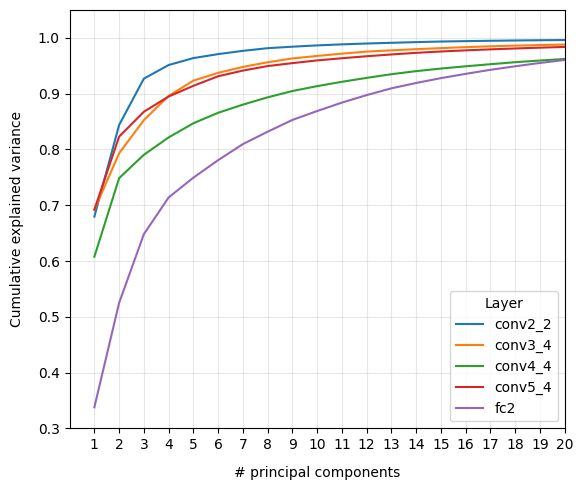

In [4]:
vgg19_df = summary[(summary["model"] == "vgg19") & (summary["component"] <= 20)]

plt.figure(figsize=(6, 5))

for layer in vgg19_df["layer"].unique():
    layer_df = vgg19_df[vgg19_df["layer"] == layer]
    plt.plot(layer_df["component"], layer_df["mean_cev"], label=layer)

plt.xlabel("# principal components", labelpad=10)
plt.ylabel("Cumulative explained variance", labelpad=10)
plt.ylim(0.3, 1.05)
plt.xlim(0, 20)
plt.grid(alpha=0.3)
plt.legend(title="Layer", loc="lower right")
plt.tight_layout()
plt.xticks(range(vgg19_df["component"].min(), vgg19_df["component"].max() + 1))

plt.savefig("./figures/vgg19_cum_explained_variance.svg", format="svg")
plt.show()